<a href="https://colab.research.google.com/github/erivetna87/DS-Unit-2-Applied-Modeling/blob/master/EricR_DS7_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [303]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install eli5==0.10.1
    !pip install pandas-profiling==2.3.0
    !pip install pdpbox==0.2.0
    !pip install plotly==4.1.1
    !pip install shap==0.30.0

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly as py
import warnings
warnings.simplefilter(action='ignore')

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train_df = pd.read_csv(train_url)
test_df  = pd.read_csv(test_url)

assert train_df.shape == (51916, 17)
assert test_df.shape  == (17306, 17)

In [0]:
#Appending the Database for Exploratory Data Analyst & prep for Pre-Processing
df = train_df.append(test_df)

In [0]:
#Getting the df cols into a list for accessibility 
df_cols = df.columns.get_values().tolist()

In [307]:
#Putting Null Values into a DataFrame for Analysis
df_null = pd.DataFrame(pd.Series(df.isnull().sum().sort_values()),
                          columns=['values']).reset_index().rename(columns={'index':'features'})
df.isnull().sum().sort_values()

Inspection ID          0
Inspection Date        0
Address                0
Fail                   0
DBA Name               0
Inspection Type        1
License #              7
State                 12
Risk                  19
Zip                   34
City                  71
Location             259
Latitude             259
Longitude            259
Facility Type        311
AKA Name             845
Violations         12935
dtype: int64

In [308]:
#Violations Column is missing from most of the dataset(s)
#Likely Represents no Violations on the business
px.bar(data_frame = df_null
       , x='values'
       , y='features'
       , template= "ggplot2"
       , title='Number of Null Values'
       , height= 900
       , width = 900
       , orientation='h'
      )

In [309]:
#Exploration of Lat/Long through Scatterplotting
import plotly.express as px
fig = px.scatter(df, x="Latitude", y="Longitude")
fig.show()

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
#Using NumPy to get 60% train, 20% val, 20% test
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [0]:
#Data Wrangling Function
def wrangle(X):
  x = X.copy()

  x = X.drop(columns='Location',inplace=True)
  
  unusable_variance = ['DBA Name','Inspection ID', 'License #','Address','AKA Name','Zip','State']

  x = X.drop(columns=unusable_variance,inplace=True)

  X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)

  X['Violations'] = X['Violations'].replace(np.NaN,'None')

  X['year_recorded'] = X['Inspection Date'].dt.year
  X['month_recorded'] = X['Inspection Date'].dt.month
  X['day_recorded'] = X['Inspection Date'].dt.day
  X = X.drop(columns='Inspection Date')

  
  return X

#Assigning Train/Val/Test 60/20/20 split to variable names for modeling
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [312]:
#Assinging X_ & Y_ to target & feature sets
target = 'Fail'
X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

print(' Train Shapes:',
      X_train.shape,
      y_train.shape,
      ('\n'),
      'Validate Shapes:',
      X_val.shape,
      y_val.shape,
      ('\n'),
      'Test Shapes:',
      X_test.shape,
      y_test.shape)

 Train Shapes: (41533, 10) (41533,) 
 Validate Shapes: (13844, 10) (13844,) 
 Test Shapes: (13845, 10) (13845,)


In [313]:
#Modeling prediction with KNeighborsClassifier
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    KNeighborsClassifier(n_neighbors=150)
)

pipeline.fit(X_train, y_train);
pipeline.fit(X_val,y_val);
pipeline.fit(X_test,y_test)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk', 'City',
                                      'Inspection Type', 'Violations'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Restaurant                                      1
Grocery Store                                   2
School                                          3
Liquor                                          4
Daycare (2 - 6 Years)                           5
Catering                                        6
Daycare Above and Under 2 Years                 7...
Length: 33774, dtype: int64}],
                                return_df=True, verbose=0)),
                ('simpleimputer',
 

In [0]:
#Getting Probability set for scoring
probabilities = pipeline.predict_proba(X_val)
y_probabilities = probabilities[:,1]


In [0]:
#Getting Prediction set for scoring
y_pred = pipeline.predict(X_val)

In [316]:
#KNeighClass Score
kAcc = accuracy_score(y_val, y_pred)
print('KNeighborsClassifer Accuracy Score: {}'.format(round(kAcc,3)*100)+'%')

KNeighborsClassifer Accuracy Score: 73.4%


In [317]:
#ROC Score
rocAucScore = roc_auc_score(y_val, y_probabilities)
print('Receiver operating characteristic: {}'.format(round(rocAucScore,3)*100)+'%' )

Receiver operating characteristic: 62.0%


In [0]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_probabilities)

In [319]:
from sklearn.metrics import f1_score
f1 = f1_score(y_val, y_pred)
print(f1)

0.0


In [320]:
from sklearn.metrics import auc
auc = auc(recall, precision)
print(auc)

0.3620738192546481


In [0]:
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_val, y_probabilities)

In [322]:
print('{}, {}, {}'.format(round(f1,3), round(auc,3), round(ap,3)))


0.0, 0.362, 0.359


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

Text(0, 0.5, 'True Positive Rate')

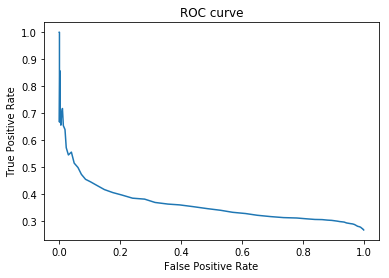

In [323]:
plt.plot(recall,precision)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [324]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)


gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.002175674123586102


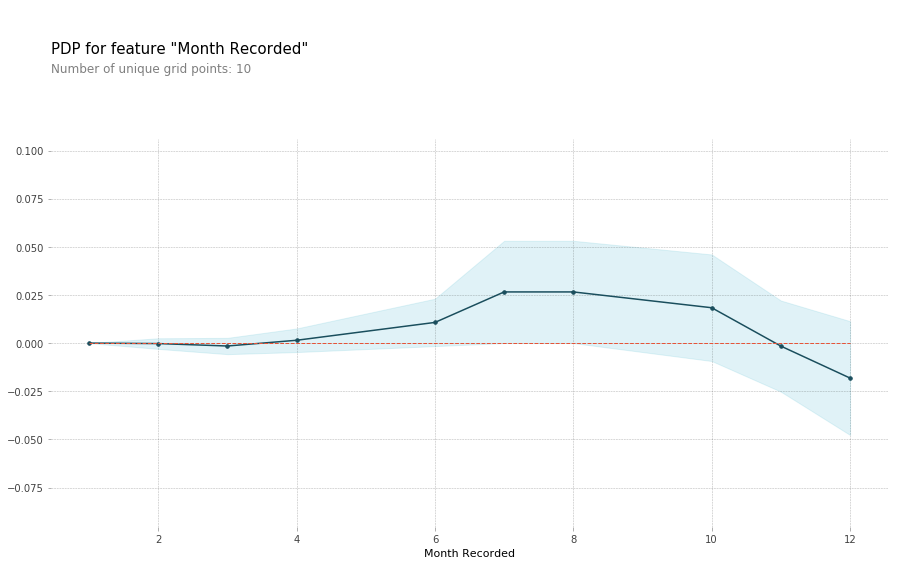

In [325]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from xgboost import XGBRegressor

feature = 'month_recorded'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature= feature
)

pdp_plot(isolated, feature_name='Month Recorded');

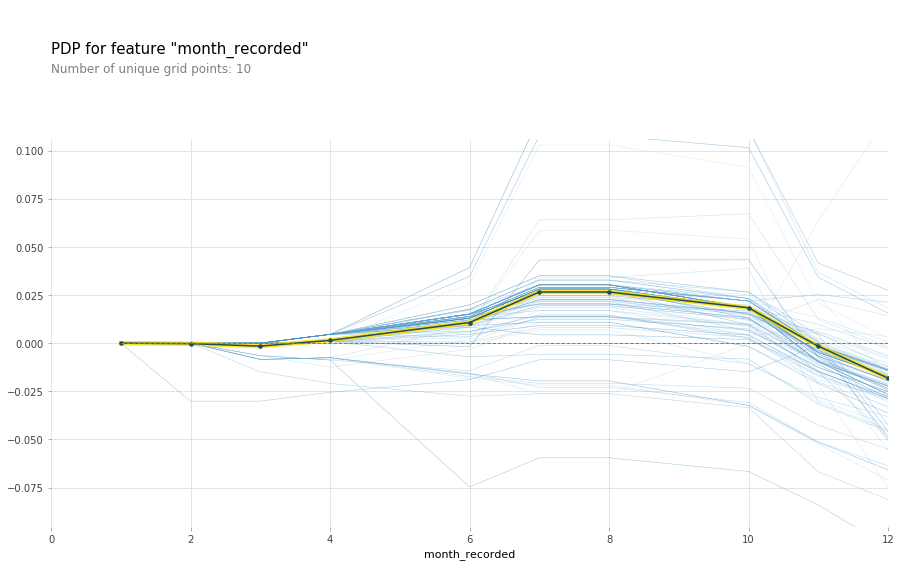

In [326]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100) # Plot 100 ICE lines
plt.xlim(0,12);

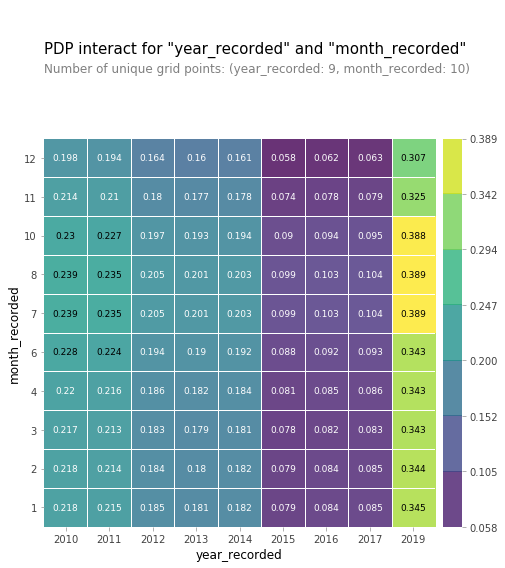

In [327]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['year_recorded','month_recorded']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);


In [328]:
from xgboost import XGBClassifier
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.647462	validation_1-auc:0.492874
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.647554	validation_1-auc:0.492874
[2]	validation_0-auc:0.647486	validation_1-auc:0.492874
[3]	validation_0-auc:0.647554	validation_1-auc:0.492874
[4]	validation_0-auc:0.647532	validation_1-auc:0.492874
[5]	validation_0-auc:0.647532	validation_1-auc:0.492874
[6]	validation_0-auc:0.659561	validation_1-auc:0.519618
[7]	validation_0-auc:0.660703	validation_1-auc:0.519601
[8]	validation_0-auc:0.661199	validation_1-auc:0.519618
[9]	validation_0-auc:0.661633	validation_1-auc:0.519597
[10]	validation_0-auc:0.674753	validation_1-auc:0.52896
[11]	validation_0-auc:0.674156	validation_1-auc:0.528988
[12]	validation_0-auc:0.674784	validation_1-auc:0.52896
[13]	validation_0-auc:0.674951	validation_1-auc:0.52896
[14]	validation_0-auc:0.683059	validation_1-auc:0.532378
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [329]:
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6576350340515799


In [330]:
model.predict_proba(X_test_processed)

array([[0.9861107 , 0.01388934],
       [0.7255326 , 0.2744674 ],
       [0.8878227 , 0.11217731],
       ...,
       [0.51034427, 0.48965576],
       [0.9781323 , 0.02186767],
       [0.3886993 , 0.6113007 ]], dtype=float32)

In [331]:
model.predict_proba(X_test_processed)[:, 0]

array([0.9861107 , 0.7255326 , 0.8878227 , ..., 0.51034427, 0.9781323 ,
       0.3886993 ], dtype=float32)

In [332]:
model.predict_proba(X_test_processed)[:, 1]

array([0.01388934, 0.2744674 , 0.11217731, ..., 0.48965576, 0.02186767,
       0.6113007 ], dtype=float32)